In [1]:
!pip install xbatcher tensorboard

In [3]:
import torch
import xbatcher
from torch.utils.data import Dataset, DataLoader
import torch
import zarr
import numpy as np
import xarray as xr
import os
from importlib import reload

if 'notebooks' in os.getcwd():
    os.chdir("..")

import util

/home/jovyan/MLGEO2024_ForestMort/util/__init__.py:21: UserWarning: Earth Engine API not found! Module util.gee will not be loaded.
  warnings.warn("Earth Engine API not found! Module util.gee will not be loaded.")


## 3D Conv-net

Input is (x: 5, y: 5, t: 4). Output is the central pixel in the next timestep.

In [2]:
damage_train = xr.open_dataset("gs://ads_training_data/damage_xyt/training.zarr", engine="zarr", chunks={}).compute()
damage_valid = xr.open_dataset("gs://ads_training_data/damage_xyt/valid.zarr", engine="zarr", chunks={}).compute()

In [4]:
def damage_reshape_fn(batch):
    X = batch["damage"].values[:, :, :, 0:-1]
    # Output: central cell in space at last
    # step in time.
    y = batch["damage"].values[:, 2, 2, -1]

    # Convert to tensors
    X = torch.tensor(X/100)
    y = torch.tensor(y/100)

    return X, y

def collator(data):
    return (
        torch.concat(tuple(d[0] for d in data)), 
        torch.unsqueeze(torch.concat(tuple(d[1] for d in data)), 1)
    )

batcher_train = xbatcher.BatchGenerator(
    damage_train,
    input_dims=dict(
        window_x=5,
        window_y=5,
        window_t=5
    ),
    batch_dims=dict(sample=32)
)

batcher_valid = xbatcher.BatchGenerator(
    damage_valid,
    input_dims=dict(
        window_x=5,
        window_y=5,
        window_t=5
    ),
    batch_dims=dict(sample=32)
)

damage_train_ds = util.training.XBatcherPyTorchDataset(batcher_train, damage_reshape_fn)
damage_valid_ds = util.training.XBatcherPyTorchDataset(batcher_valid, damage_reshape_fn)

damage_train_loader = DataLoader(damage_train_ds, batch_size=4, shuffle=True, collate_fn=collator)
damage_valid_loader = DataLoader(damage_valid_ds, batch_size=4, shuffle=True, collate_fn=collator)

NameError: name 'damage_train' is not defined

In [5]:
class DamageConv3D(torch.nn.Module):
    def __init__(self):
        super(DamageConv3D, self).__init__()
        self.conv1 = self._conv_layer_set(1, 8)
        self.conv2 = self._conv_layer_set(8, 16)
        self.flat = torch.nn.Flatten()
        self.relu = torch.nn.LeakyReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.fc1 = torch.nn.Linear(288, 16)
        self.fc2 = torch.nn.Linear(16, 1)
        self.drop = torch.nn.Dropout(p=0.2)

    @staticmethod
    def _conv_layer_set(in_channels, out_channels):
        conv_layer = torch.nn.Sequential(
            torch.nn.Conv3d(
                in_channels, 
                out_channels, 
                kernel_size=(2, 2, 2), 
                stride=1,
                padding=0,
                ),
            torch.nn.LeakyReLU(),
            )
        return conv_layer

    def forward(self, x):
        # Add a channel axis to make 3d conv layers happy
        x = torch.unsqueeze(x, 1)
        
        x = self.conv1(x)
        print(x.shape)
        x = self.conv2(x)
        print(x.shape)
        x = self.flat(x)
        print(x.shape)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [6]:
cnn = DamageConv3D()
print(cnn)

DamageConv3D(
  (conv1): Sequential(
    (0): Conv3d(1, 8, kernel_size=(2, 2, 2), stride=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (conv2): Sequential(
    (0): Conv3d(8, 16, kernel_size=(2, 2, 2), stride=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (relu): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=288, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)


In [10]:
x = torch.tensor(np.zeros((1, 5, 5, 4))).type(torch.float32)

cnn.forward(x)

torch.Size([1, 8, 4, 4, 3])
torch.Size([1, 16, 3, 3, 2])
torch.Size([1, 288])


tensor([[0.4587]], grad_fn=<SigmoidBackward0>)

In [8]:
opt = torch.optim.Adam(cnn.parameters(), lr=0.005)
damage_trainer = util.training.Trainer(
    cnn, opt, torch.nn.BCELoss(),
    damage_train_loader, damage_valid_loader,
    n_batches=500, n_epochs=20,
    model_log="logs/damage_3d/3dcnn.pt",
    perf_log="logs/damage_3d/3dcnn_performance",
    timing_log="logs/damage_3d/3dcnn_timing.log"
)

In [ ]:
damage_trainer.train()

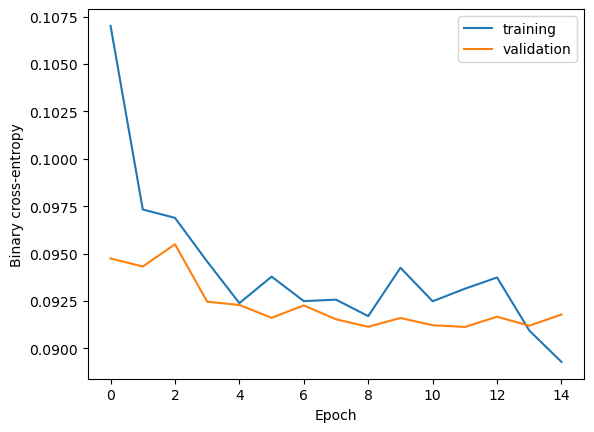

In [10]:
from matplotlib import pyplot as plt

perf_log = "logs/damage_3d/3dcnn_performance"

learning_curves = util.training.parse_tensorboard(
    perf_log, ["Loss/train", "Loss/valid"]
)

# Filter out an old run
train_loss = learning_curves["Loss/train"]
valid_loss = learning_curves["Loss/valid"]

fig, ax = plt.subplots()

ax.plot(train_loss["step"], train_loss["value"], label="training")
ax.plot(valid_loss["step"], valid_loss["value"], label="validation")

plt.ylabel("Binary cross-entropy")
plt.xlabel("Epoch")

plt.legend()
plt.show()

In [12]:
damage_test = xr.open_dataset("gs://ads_training_data/damage_xyt/test.zarr", engine="zarr").compute()

damage_batcher_test = xbatcher.BatchGenerator(
    damage_test,
    input_dims=dict(
        window_x=5,
        window_y=5,
        window_t=5
    ),
    batch_dims=dict(sample=32)
)
damage_test_ds = util.training.XBatcherPyTorchDataset(damage_batcher_test, damage_reshape_fn)

damage_test_loader = DataLoader(damage_test_ds, batch_size=4, shuffle=True, collate_fn=collator)

In [13]:
cnn.eval()

with torch.no_grad():
    zipped = [(y, cnn.forward(x)) for x, y in damage_test_loader]
    y, yhat = zip(*zipped)

y = torch.cat(y)
yhat = torch.cat(yhat)

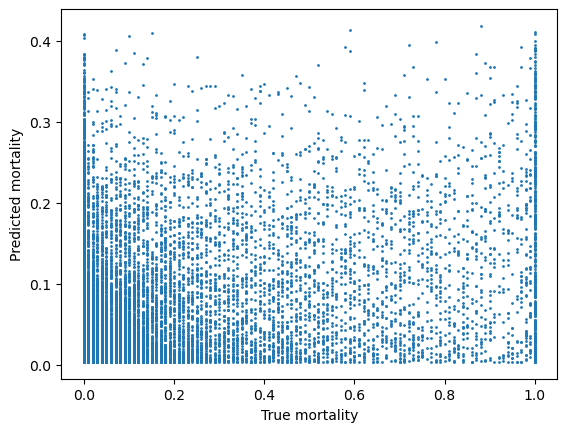

In [15]:
plt.scatter(y[::10], yhat[::10], s=1)
plt.xlabel("True mortality")
plt.ylabel("Predicted mortality")
plt.show()

In [16]:
np.corrcoef(torch.squeeze(y), torch.squeeze(yhat))

array([[1.        , 0.42555423],
       [0.42555423, 1.        ]])

In [17]:
import pandas as pd

pd.DataFrame(dict(y=torch.squeeze(y), yhat=torch.squeeze(yhat))).to_csv("logs/damage_3d/damage_3d_test_result.csv")

## Fully-connected

Input is single pixel-years

In [3]:
singles_train = xr.open_dataset("gs://ads_training_data/single_pixel_year/training.zarr", engine="zarr", chunks={}).compute()
singles_valid = xr.open_dataset("gs://ads_training_data/single_pixel_year/valid.zarr", engine="zarr", chunks={}).compute()
# singles_valid = singles_valid.isel(sample=np.random.choice(singles_valid["pixel"].shape[0], size=1000)).reset_index("sample")
# singles_valid = singles_valid.compute() # bring onto disk

In [7]:
def collator(data):
    return (
        torch.concat(tuple(d[0] for d in data)), 
        torch.unsqueeze(torch.concat(tuple(d[1] for d in data)), 1)
    )

def singles_reshape_fn(batch):
    # Input: all bands BUT mortality
    target_idx = 12
    X = np.concat(
        (batch["pixel"].values[:, 0:target_idx],
        batch["pixel"].values[:, target_idx+1:]),
        axis=1
    )
    # Output: mortality ONLY
    y = batch["pixel"].values[:, target_idx]

    # Convert to tensors
    X = torch.tensor(X)
    y = torch.tensor(y/100)

    return X, y

singles_batcher_train = xbatcher.BatchGenerator(
    singles_train,
    input_dims=dict(
        band=16
    ),
    batch_dims=dict(sample=32)
)

singles_batcher_valid = xbatcher.BatchGenerator(
    singles_valid,
    input_dims=dict(
        band=16
    ),
    batch_dims=dict(sample=32)
)

singles_train_ds = util.training.XBatcherPyTorchDataset(singles_batcher_train, singles_reshape_fn)
singles_valid_ds = util.training.XBatcherPyTorchDataset(singles_batcher_valid, singles_reshape_fn)

singles_train_loader = DataLoader(singles_train_ds, batch_size=4, shuffle=True, collate_fn=collator)
singles_valid_loader = DataLoader(singles_valid_ds, batch_size=4, shuffle=True, collate_fn=collator)

In [8]:
eg_x, eg_y = next(iter(singles_train_loader))

In [9]:
class SinglePixelFC(torch.nn.Module):
    '''
    Simple fully-connected NN for use with single pixels.
    '''
    def __init__(self, input_features):
        super(SinglePixelFC, self).__init__()
        self.bn = torch.nn.BatchNorm1d(input_features)
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.drop = torch.nn.Dropout(p=0.2)
        self.fc1 = torch.nn.Linear(input_features, 128)
        self.fc2 = torch.nn.Linear(128, 16)
        self.fc3 = torch.nn.Linear(16, 1)

    def forward(self, x):
        x = self.bn(x)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.drop(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.drop(x)

        x = self.fc3(x)
        x = self.sigmoid(x)

        return x

In [10]:
fc = SinglePixelFC(input_features=eg_x.shape[1])
print(fc.forward(eg_x).shape)

torch.Size([128, 1])


In [11]:
model_name = "singles_bce"
model_log = f"logs/{model_name}/{model_name}.pt"
perf_log = f"logs/{model_name}/{model_name}_performance"

opt2 = torch.optim.SGD(fc.parameters(), lr=0.005)
singles_trainer = util.training.Trainer(
    fc, opt2, torch.nn.BCELoss(),
    singles_train_loader, singles_valid_loader,
    n_batches=500, n_epochs=50,
    model_log=model_log,
    perf_log=perf_log
    #timing_log="logs/singles/singles_timing.log"
)

In [ ]:
singles_trainer.train()

In [13]:
learning_curves = util.training.parse_tensorboard(
    perf_log, ["Loss/train", "Loss/valid"]
)

In [14]:
from matplotlib import pyplot as plt

# Filter out an old run
train_loss = learning_curves["Loss/train"]
valid_loss = learning_curves["Loss/valid"]

#train_loss = train_loss[train_loss["wall_time"] > 1.733e9+700000]
#valid_loss = valid_loss[valid_loss["wall_time"] > 1.733e9+700000]

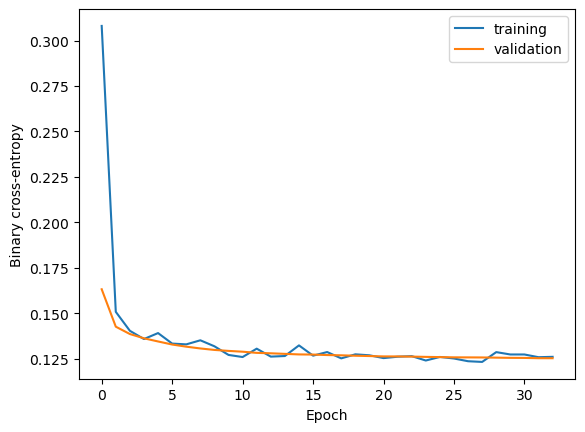

In [15]:
fig, ax = plt.subplots()

ax.plot(train_loss["step"], train_loss["value"], label="training")
ax.plot(valid_loss["step"], valid_loss["value"], label="validation")

plt.ylabel("Binary cross-entropy")
plt.xlabel("Epoch")

plt.legend()
plt.show()

In [16]:
# Show predictions on test set
singles_test = xr.open_dataset("gs://ads_training_data/single_pixel_year/test.zarr", engine="zarr").compute()

In [17]:
singles_batcher_test = xbatcher.BatchGenerator(
    singles_test,
    input_dims=dict(
        band=16
    ),
    batch_dims=dict(sample=32)
)

singles_test_ds = util.training.XBatcherPyTorchDataset(singles_batcher_test, singles_reshape_fn)

singles_test_loader = DataLoader(singles_test_ds, batch_size=4, shuffle=True, collate_fn=collator)

In [18]:
x, y = next(iter(singles_test_loader))

In [19]:
fc.eval()

with torch.no_grad():
    zipped = [(y, fc.forward(x)) for x, y in singles_test_loader]
    y, yhat = zip(*zipped)

In [20]:
y = torch.cat(y)
yhat = torch.cat(yhat)

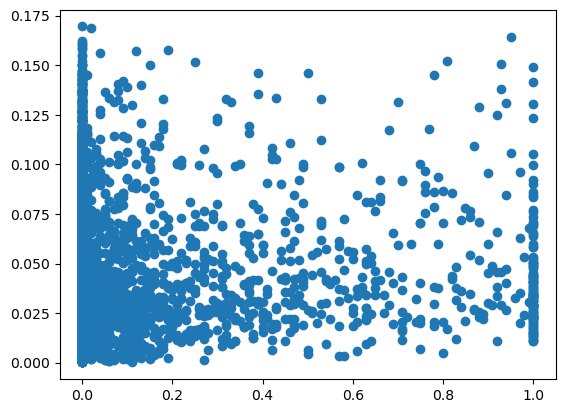

In [22]:
plt.scatter(y[::100], yhat[::100])

In [23]:
import pandas as pd
pd.DataFrame(dict(y=torch.squeeze(y), yhat=torch.squeeze(yhat))).to_csv("logs/singles_bce/singles_bce_test_result.csv")

In [24]:
y = torch.squeeze(y)
yhat = torch.squeeze(yhat)

In [25]:
np.corrcoef(y, yhat)

array([[1.        , 0.18241657],
       [0.18241657, 1.        ]])

## Plot timing

average batch duration 1.118912358717485
average wait time 3.3380560131247985


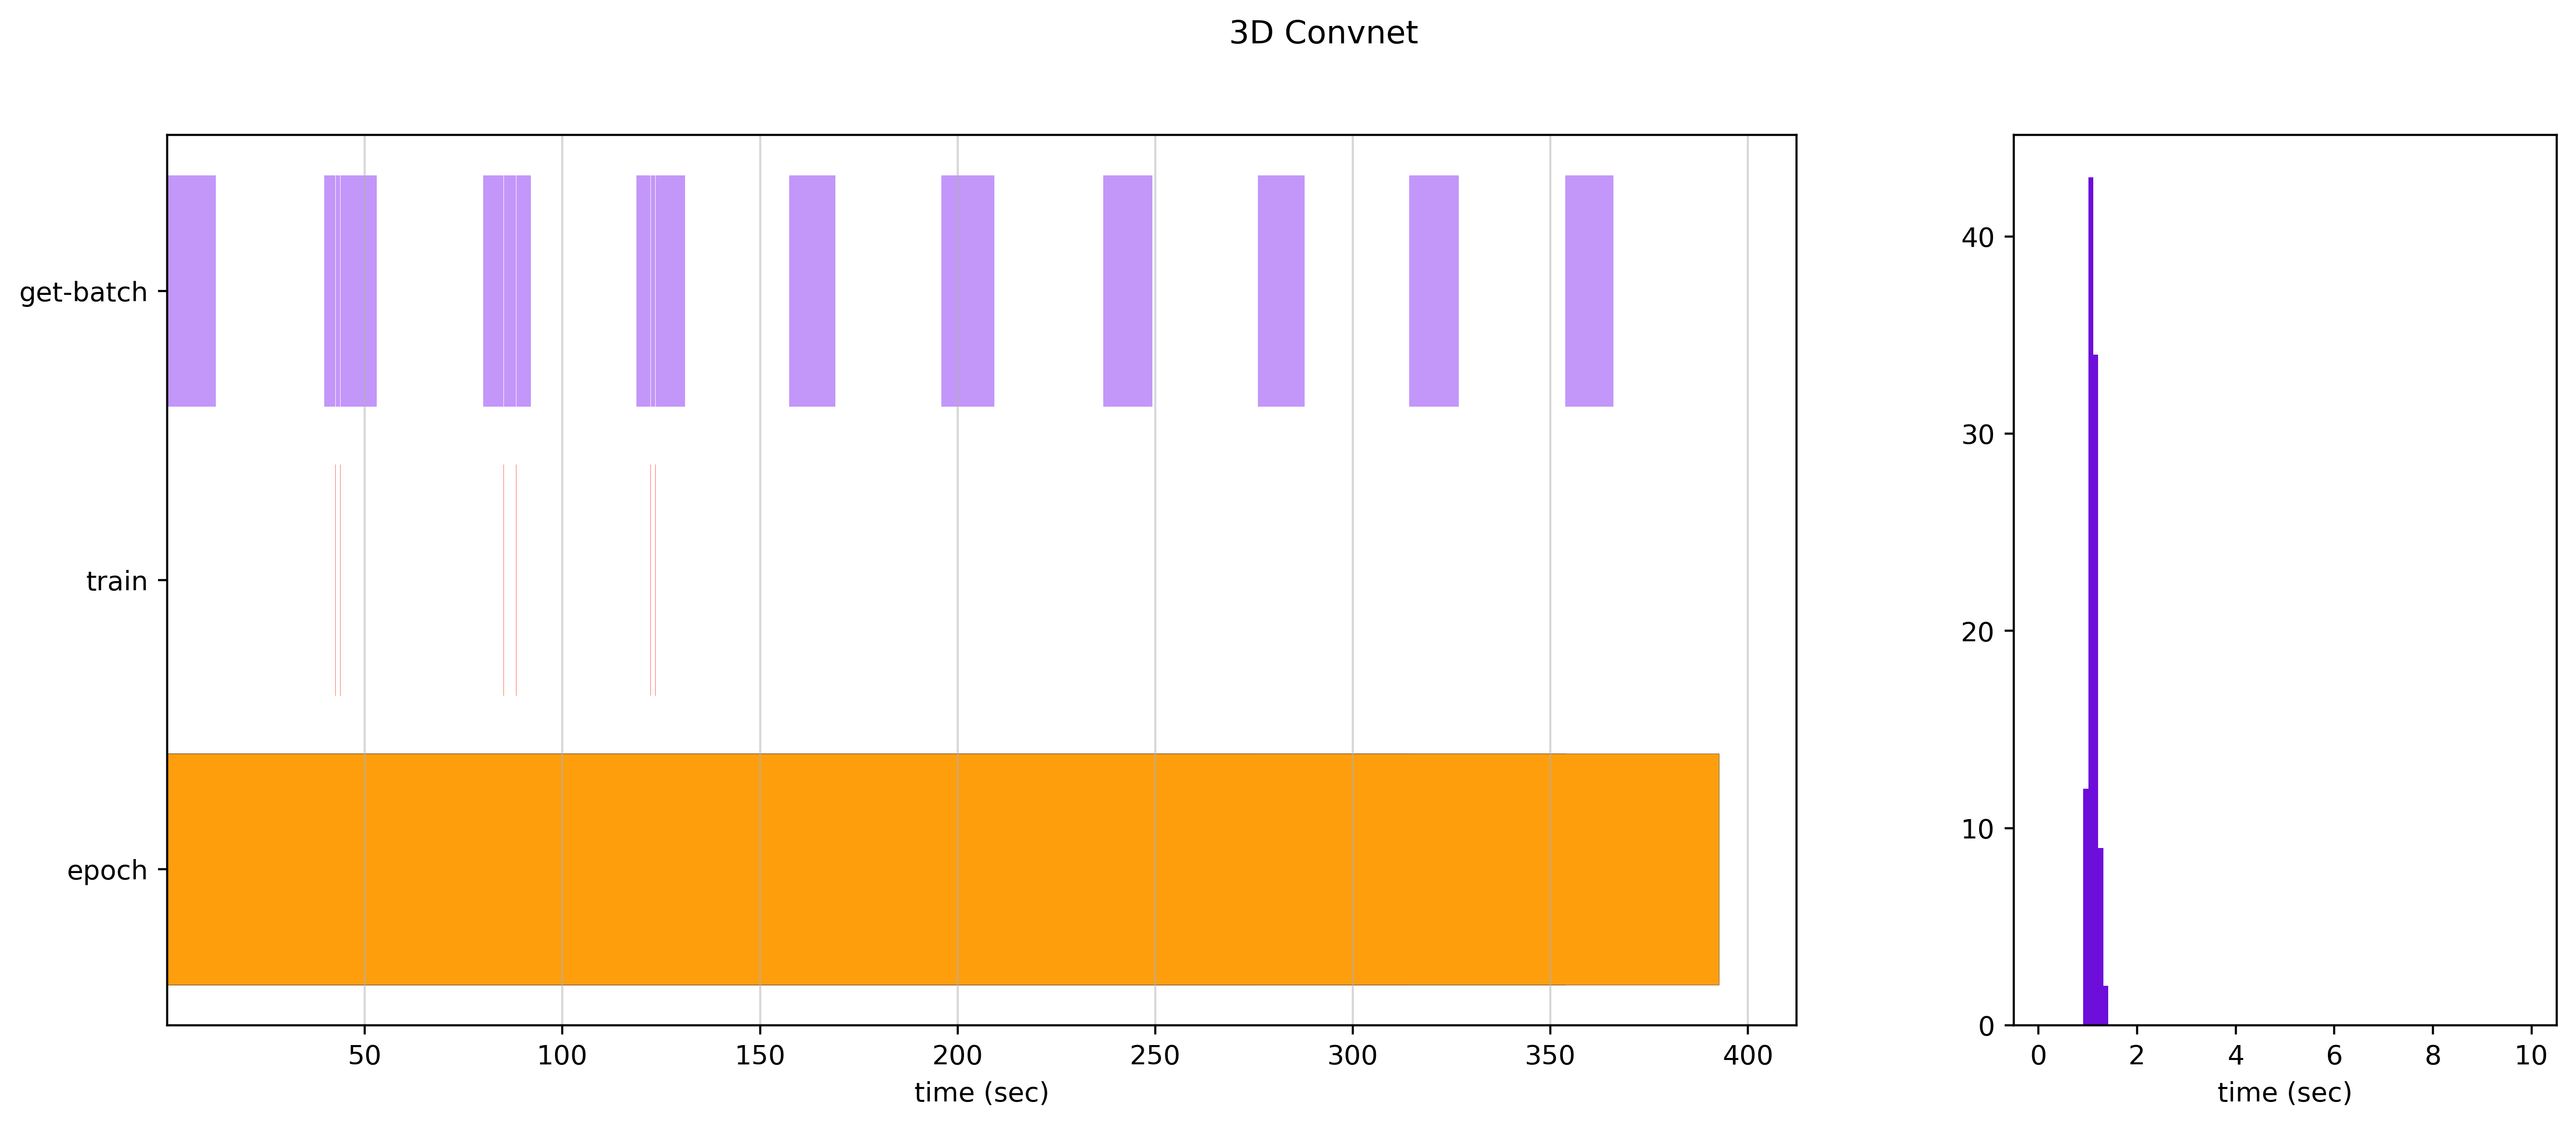

In [22]:
from matplotlib import pyplot as plt
util.plot.plot("logs/damage_3d/3dcnn_timing.log")
plt.suptitle("3D Convnet")
plt.show()

average batch duration 0.5070872631939974
average wait time 0.5096638793245368


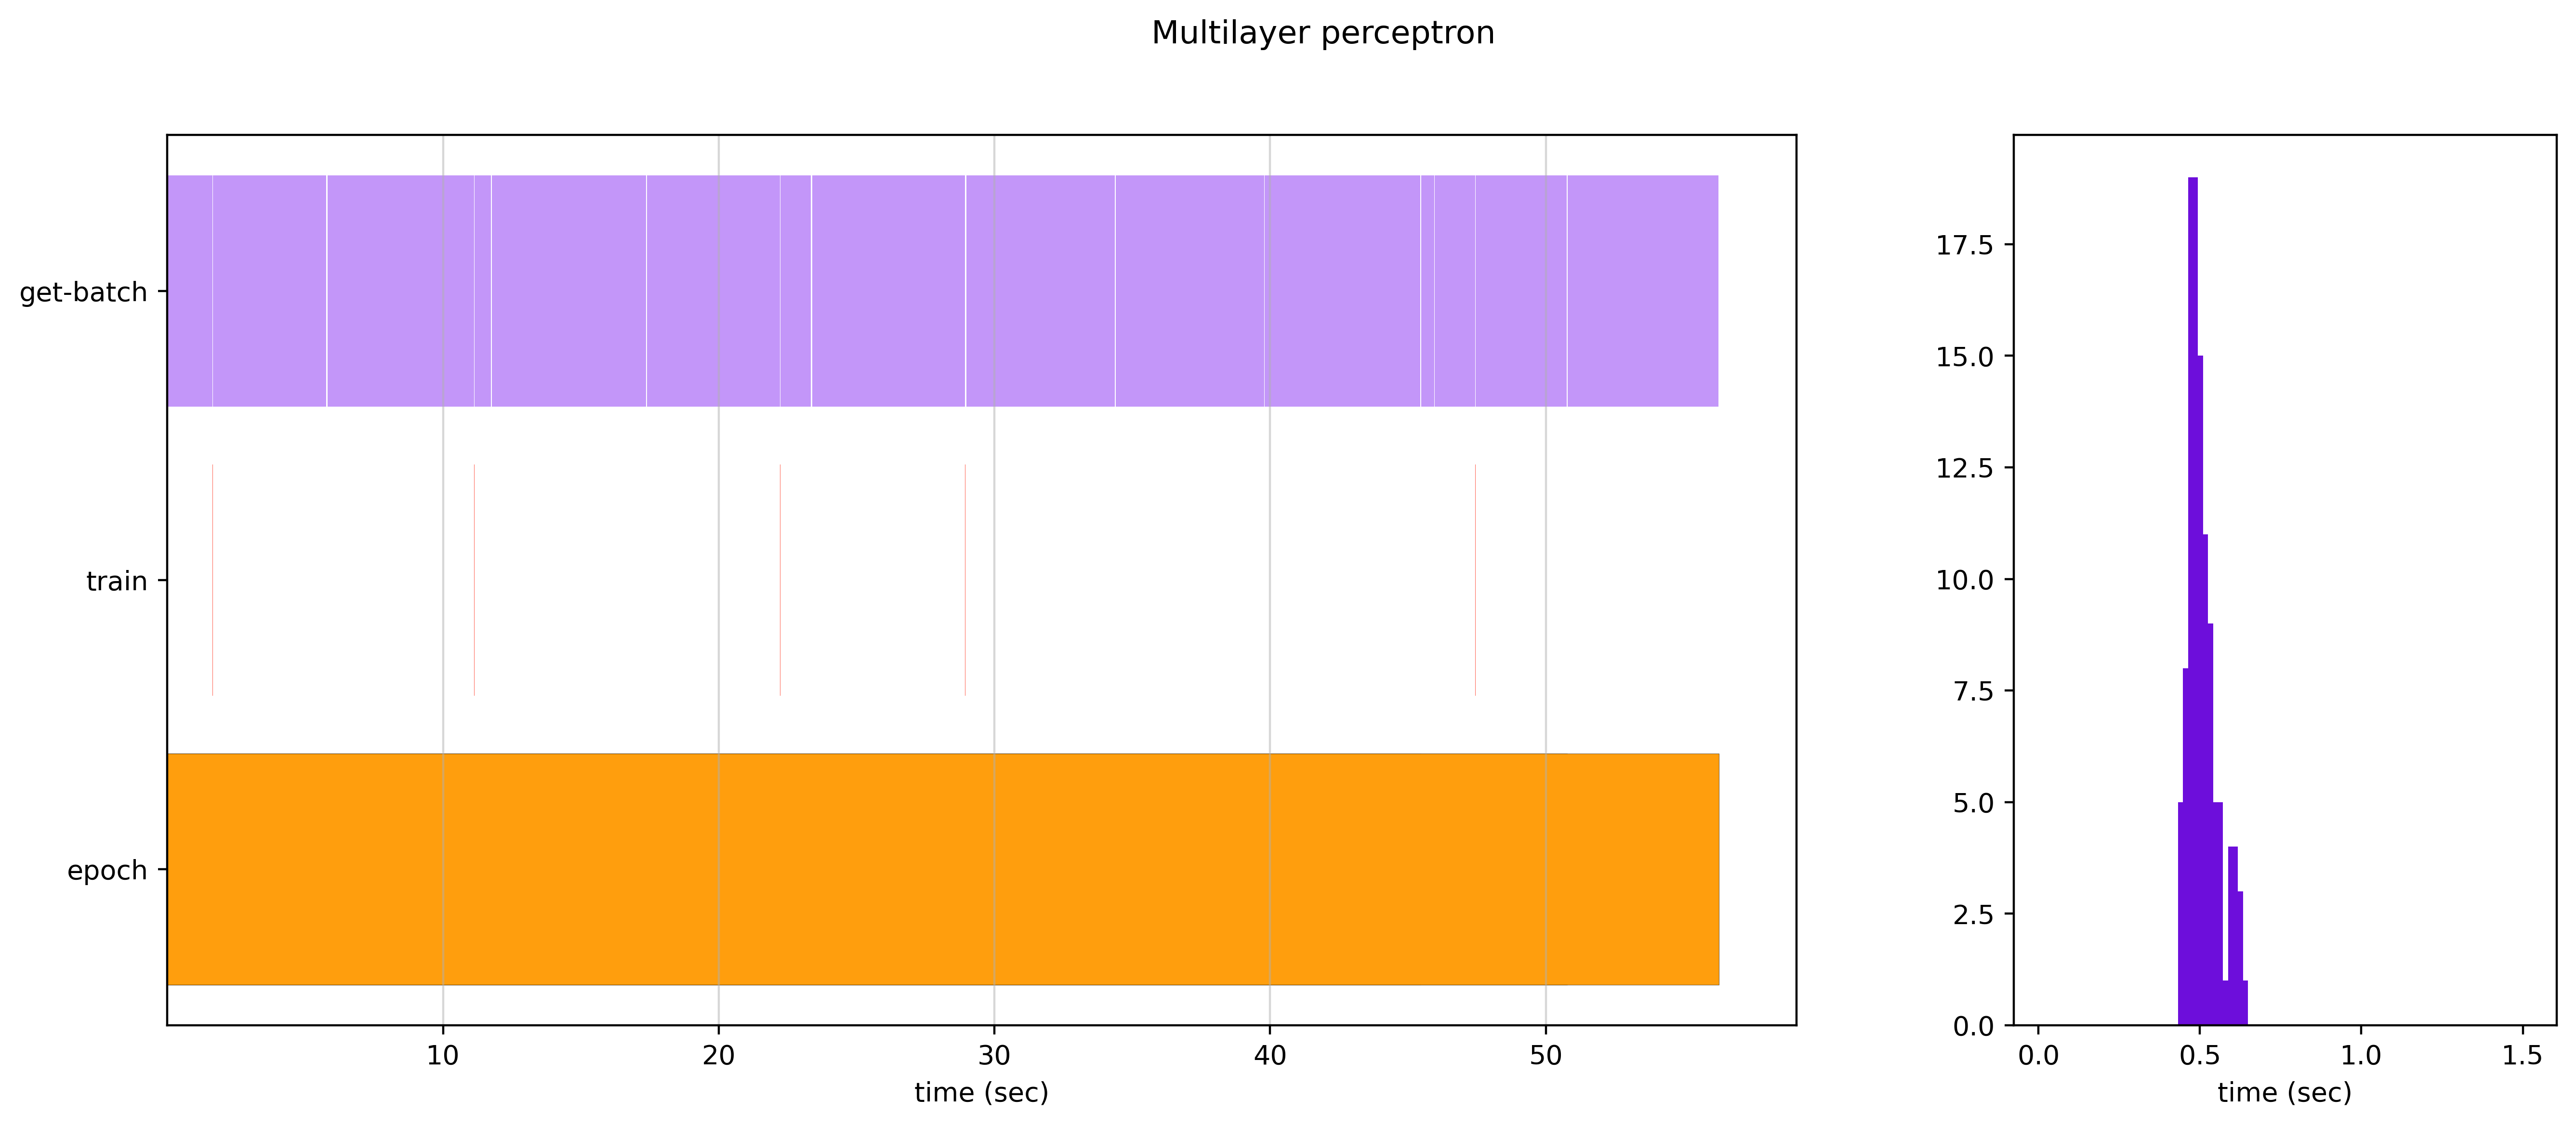

In [23]:
util.plot.plot("logs/singles/singles_timing.log")
plt.suptitle("Multilayer perceptron")
plt.show()